# Student's t Distribution with NGBoost

**Problem**: Robust regression for data with heavier tails than Normal.

**When to use**:
- Financial risk modeling: returns with fat tails
- Scientific measurements with occasional extreme outliers
- Any regression where Normal is too light-tailed

**Variants available**:
- `TFixedDf` — 2 parameters: loc, scale (df fixed at 3) — recommended starting point
- `T` — 3 parameters: loc, scale, df (df learned from data)
- `TFixedDfFixedVar` — 1 parameter: loc only (df=3, scale=1)
- `Cauchy` — 2 parameters: loc, scale (df=1, extremely heavy tails)

In [1]:
import sys
sys.path.insert(0, '..')  # add project root so 'import ngboost' finds the package

In [2]:
import numpy as np
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from ngboost import NGBRegressor
from ngboost.distns import TFixedDf, Cauchy

## 1. Generate synthetic heavy-tailed data

In [3]:
np.random.seed(42)
n_samples = 1000
X = np.random.randn(n_samples, 5)

true_loc = 2.0 + 1.5 * X[:, 0] - 1.0 * X[:, 1]
true_scale = 1.5
true_df = 4.0  # moderately heavy tails
Y = true_loc + true_scale * np.random.standard_t(true_df, size=n_samples)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Y range: [{Y.min():.1f}, {Y.max():.1f}]")
print(f"Y mean: {Y.mean():.2f}, Y std: {Y.std():.2f}")
print(f"Train: {len(Y_train)}, Test: {len(Y_test)}")

Y range: [-13.6, 21.9]
Y mean: 1.93, Y std: 2.96
Train: 800, Test: 200


## 2. Train NGBoost with TFixedDf

`TFixedDf` uses df=3, giving heavier tails than Normal while keeping
optimization simple (2 parameters: loc and scale).

In [4]:
ngb = NGBRegressor(
    Dist=TFixedDf,
    n_estimators=300,
    learning_rate=0.05,
    verbose=False,
    random_state=42,
)
ngb.fit(X_train, Y_train)
print("Training complete.")

d:\Users\guyko\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:7625: RuntimeWarning: overflow encountered in multiply
  - (df + 1)/2*np.log1p(x * x/df))
d:\Users\guyko\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2029: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
d:\Users\guyko\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:7625: RuntimeWarning: overflow encountered in multiply
  - (df + 1)/2*np.log1p(x * x/df))
d:\Users\guyko\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2029: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
d:\Users\guyko\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:7625: RuntimeWarning: overflow encountered in multiply
  - (df + 1)/2*np.log1p(x * x/df))
d:\Users\guyko\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2029: RuntimeWarning: divide by zero encountered 

Training complete.


## 3. Predictions and parameters

In [5]:
dists = ngb.pred_dist(X_test)
Y_pred = ngb.predict(X_test)

print("Estimated parameters (first 5 test samples):")
print(f"  loc:   {dists.loc[:5].round(3)}")
print(f"  scale: {dists.scale[:5].round(3)}")
print(f"  df:    {dists.df[:5].round(1)} (fixed)")
print(f"\nPredicted (first 5): {Y_pred[:5].round(2)}")
print(f"Actual (first 5):     {Y_test[:5].round(2)}")

Estimated parameters (first 5 test samples):
  loc:   [ 2.203 -1.419  1.225  3.097  0.536]
  scale: [2.479 1.417 1.509 1.263 1.257]
  df:    [3. 3. 3. 3. 3.] (fixed)

Predicted (first 5): [ 2.2  -1.42  1.22  3.1   0.54]
Actual (first 5):     [ 3.42 -1.81 -1.23  2.36  0.  ]


## 4. Quantiles and prediction intervals

In [6]:
q10 = dists.ppf(0.1)
q90 = dists.ppf(0.9)

coverage = np.mean((Y_test >= q10) & (Y_test <= q90))
print(f"80% prediction interval coverage: {coverage:.1%} (target: 80%)")

mse = np.mean((Y_test - Y_pred) ** 2)
print(f"Test MSE: {mse:.3f}")

80% prediction interval coverage: 75.5% (target: 80%)
Test MSE: 7.746


## 5. Cauchy — extremely heavy tails

`Cauchy` is equivalent to Student's t with df=1. It has no finite mean
or variance — useful when data has very extreme outliers.

In [7]:
ngb_cauchy = NGBRegressor(
    Dist=Cauchy,
    n_estimators=300,
    learning_rate=0.05,
    verbose=False,
    random_state=42,
)
ngb_cauchy.fit(X_train, Y_train)
dists_cauchy = ngb_cauchy.pred_dist(X_test)

q10_c = dists_cauchy.ppf(0.1)
q90_c = dists_cauchy.ppf(0.9)
coverage_c = np.mean((Y_test >= q10_c) & (Y_test <= q90_c))

print(f"TFixedDf (df=3): 80% PI coverage = {coverage:.1%}")
print(f"Cauchy (df=1):   80% PI coverage = {coverage_c:.1%}")

d:\Users\guyko\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2029: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
d:\Users\guyko\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:7625: RuntimeWarning: overflow encountered in multiply
  - (df + 1)/2*np.log1p(x * x/df))
d:\Users\guyko\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2029: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
d:\Users\guyko\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:7625: RuntimeWarning: overflow encountered in multiply
  - (df + 1)/2*np.log1p(x * x/df))
d:\Users\guyko\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2029: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
d:\Users\guyko\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:7625: RuntimeWarning: overflow enc

TFixedDf (df=3): 80% PI coverage = 75.5%
Cauchy (df=1):   80% PI coverage = 88.5%


## 6. Visualize

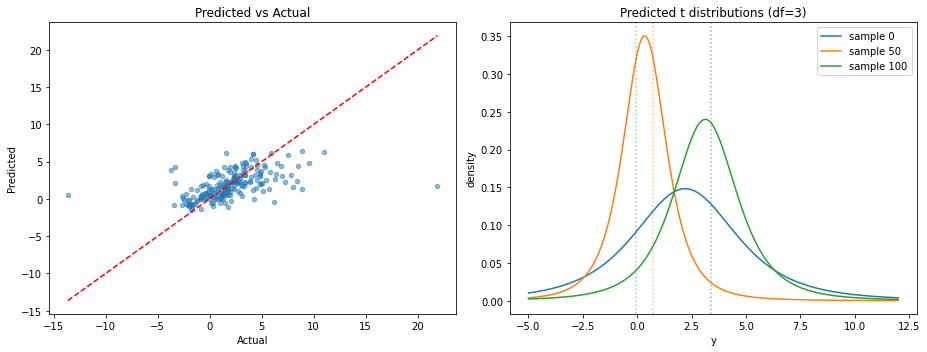

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ax = axes[0]
ax.scatter(Y_test, Y_pred, alpha=0.5, s=20)
lims = [Y_test.min(), Y_test.max()]
ax.plot(lims, lims, "r--")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title("Predicted vs Actual")

ax = axes[1]
x = np.linspace(-5, 12, 300)
for i in [0, 50, 100]:
    pdf = scipy.stats.t.pdf(x, df=dists.df[i], loc=dists.loc[i], scale=dists.scale[i])
    ax.plot(x, pdf, label=f"sample {i}")
    ax.axvline(Y_test[i], color=ax.lines[-1].get_color(), linestyle=":", alpha=0.5)
ax.set_xlabel("y")
ax.set_ylabel("density")
ax.set_title("Predicted t distributions (df=3)")
ax.legend()

plt.tight_layout()
plt.show()

## Note: T with learnable df

The `T` distribution learns `df` as a third parameter alongside `loc` and
`scale`. This is more flexible but harder to train — the `df` parameter
can become numerically unstable (overflow in `exp(log_df)`).

For most applications, `TFixedDf` with df=3 provides good robustness.
Use `T` only when learning the tail heaviness is critical and you're
prepared to tune hyperparameters carefully (lower learning rate, shallower
trees, more estimators).